# Example: State Space Models of the Excess Return Distribution
Fill me in

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
Precompiling project...
  ✓ VLQuantitativeFinancePackage
  1 dependency successfully precompiled in 3 seconds. 282 already precompiled.
  Activating project at `~/Desktop/julia_work

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable. The dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable.

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [11]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value), and we'll specify the number of trading days to simulate in the `T` variable:

In [13]:
Δt = (1.0/252.0);
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;
risk_free_rate = 0.045;

## Specify a ticker of interest
Fill me in

In [15]:
all_firms_growth_matrix = log_return_matrix(dataset, list_of_all_firms, Δt = Δt, 
    risk_free_rate = risk_free_rate);

In [16]:
ticker_of_interest = "AMD";
excess_growth_rate_array = findfirst(x->x==ticker_of_interest,list_of_all_firms) |> i -> all_firms_growth_matrix[:,i];

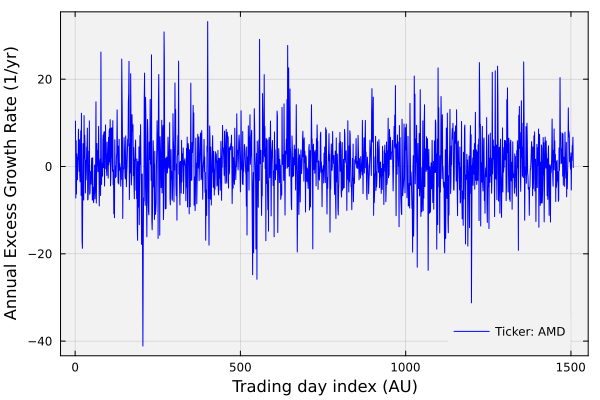

In [17]:
plot(excess_growth_rate_array, label="Ticker: $(ticker_of_interest)", c=:blue, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
xlabel!("Trading day index (AU)", fontsize=18)
ylabel!("Annual Excess Growth Rate (1/yr)", fontsize=18)

## Build the HiPPO-LegS model instance
We construct an instance of the [MySisoLegSHippoModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MySisoLegSHippoModel) using a specialized [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MySisoLegSHippoModel},%20NamedTuple}) for this model type. We store the [MySisoLegSHippoModel](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MySisoLegSHippoModel) instance in the `model` variable. To begin, we specify some data required to build the `model` instance:
* Specify the `tspan::NamedTuple` variable, which holds information about the time span of the model training; the `start::Float64` field is the time start, the `stop::Float64` field is the time stop, and the `step::Float64` is the time step. Next, construct the input sequence the model will learn and store this in the `signal::Array{Float64,1}` variable. In this example, we'll use the first `L` annualized excess growth rate values we previously stored in the `excess_growth_rate_array` variable; these are the return values for the `ticker_of_interest` for a range of `1:L`. We are learning `3-years` of `daily` price data in this case.

In [19]:
tspan = (start = 0.0, stop = 3.0, step = Δt)
L = range(tspan.start, stop=tspan.stop, step = tspan.step) |> collect |> length
signal = excess_growth_rate_array[1:L];

To build the [MySisoLegSHippoModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MySisoLegSHippoModel), which holds data about this model, we use a specialized [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MySisoLegSHippoModel},%20NamedTuple}). In particular, we pass the `number_of_hidden_states` variable, the time step `Δt,` the initial signal value `uₒ` and an initial guess of the `C` matrix to the [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MySisoLegSHippoModel},%20NamedTuple}) and it returns a populated [MySisoLegSHippoModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MySisoLegSHippoModel):
* The [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MySisoLegSHippoModel},%20NamedTuple}) populates the $\mathbf{A}$ and $\mathbf{B}$ matrices according to the [HiPPO LegS parameterization](https://arxiv.org/abs/2008.07669) and uses a bilinear discretization scheme to compute the discrete $\hat{\mathbf{A}}$ and $\hat{\mathbf{B}}$ matrices. The discrete matrix $\hat{\mathbf{C}}$ is estimated from data using the [estimate_hippo_parameters function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.estimate_hippo_parameters-Tuple{MySisoLegSHippoModel,%20NamedTuple,%20Array{Float64}}), see below for further discussion of model identification.

In [21]:
number_of_hidden_states = 250;
model = build(MySisoLegSHippoModel, (
    number_of_hidden_states = number_of_hidden_states,
    Δt = Δt,
    uₒ = signal[1],
    C = 2*randn(number_of_hidden_states) # 1 x number_of_hidden_states since we have a single output
));

Before we estimate the $\hat{\mathbf{C}}$ matrix, let's run the model once to compare the `untrained` simulations with simulations following model training. To solve the [HiPPO model](https://arxiv.org/abs/2008.07669), we pass our `model` instance,  the `tspan` information, and the input `signal` that we wish to learn to the [solve function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.solve-Tuple{MySisoLegSHippoModel,%20NamedTuple,%20Array{Float64}}).
* The [solve function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.solve-Tuple{MySisoLegSHippoModel,%20NamedTuple,%20Array{Float64}}) takes the `model` instance (and the other arguments mentioned above) and returns the time vector `T,` the hidden state matrix `X` and the model output vector `Y` using the $\hat{\mathbf{A}}, \hat{\mathbf{B}}$-matrices (defined by the parameterization strategy) and the default value of the $\hat{\mathbf{C}}$ matrix (in this case a [Normally distributed](https://en.wikipedia.org/wiki/Normal_distribution) random $1\times{N}$-row vector).

In [23]:
(T1,X1,Y1) = solve(model, tspan, signal);

#### Visualize untrained model
`Unhide` the code block below to see how we plotted the untrained growth rate versus the observed growth rate for the ticker specified in the `ticker_of_interest` variable.
* __Summary__: The simulated annual excess growth rate appears random (left panel), which is what we would expect, given that we are feeding the model a random input sequence. However, the random output values are inconsistent with the input sequence (right panel). Thus, with a random $\hat{\mathbf{C}}$, the model has not memorized the input sequence.

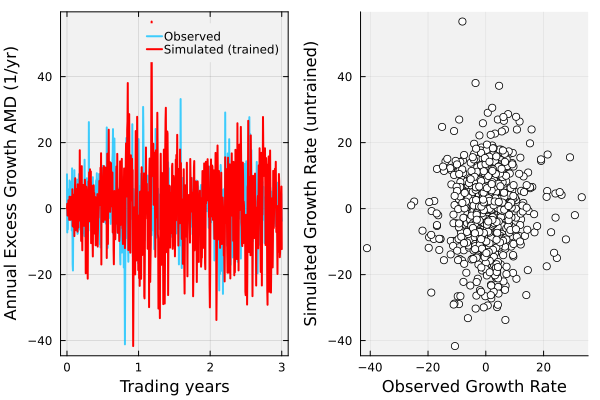

In [25]:
let
    # layout -
    l = @layout [a b]

    # time series -
    p1 = plot(T1,signal, label="Observed", lw=2, c=:deepskyblue, alpha=0.75, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
    plot!(p1, T1,Y1,label="Simulated (trained)", lw=2, c=:red, xlabel="Trading years", ylabel="Annual Excess Growth $(ticker_of_interest) (1/yr)", fontsize=18)
    
    # sim v obs
    p2 = scatter(signal, Y1, label="", xlabel="Observed Growth Rate", ylabel="Simulated Growth Rate (untrained)", c=:white, msc=:black)

    # build the plot -
    plot(p1,p2,layout=l)
end

In [76]:
corr_value = cor(signal,Y1);
println("Correclation for N = $(number_of_hidden_states) hidden states is: $(corr_value)")

Correclation for N = 250 hidden states is: 0.06901591994268876


## Train the HiPPO-LegS model instance
The `untrained` HiPPO model did not replicate the input signal. To train the model, i.e., estimate the $\hat{\mathbf{C}}$ matrix, we minimize the [squared error loss function](https://en.wikipedia.org/wiki/Loss_function):

$$
\hat{\mathbf{C}} = \arg\min_{\mathbf{C}}\sum_{i}\left(\mathbf{C}\cdot\mathbf{X}_{i}-Y\right)^{2}
$$

where $\mathbf{X}_{i}$ denotes the hidden state vector at step $i$. We do this calculation using the [estimate_hippo_parameters function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.estimate_hippo_parameters-Tuple{MySisoLegSHippoModel,%20NamedTuple,%20Array{Float64}}) which uses methods from the [Optim.jl package](https://github.com/JuliaNLSolvers/Optim.jl) to solve the underlyling optimzation problem. For this example, we've already solved the estimation problem for different values for the `number_of_hidden_states` for `SPY` and a few other tickers such as `AMD.`

* __Extra__: to estimate the $\hat{\mathbf{C}}$ matrix for a `ticker` using `number_of_hidden_states,` then `uncomment` the code block below. However, be advised the model estimation calculation can take several minutes for values of `number_of_hidden_states` $\geq$ 100. Following the conclusion of the estimation, we save the `model` instance to a file (so we can use it later). 

In [27]:
# model.C = estimate_hippo_parameters(model, tspan, signal);
# save(joinpath(_PATH_TO_DATA,"HiPPO-$(ticker_of_interest)-N$(number_of_hidden_states).jld2"), Dict("model"=>model));

Now that we have an estimate of the matrix $\hat{\mathbf{C}}$, let's use it to simulate the training input sequence and see if the model output is consistent with the input data sequence held in the `signal` vector. 
* Make a copy of the original untrained model using the [Julia deepcopy function](https://docs.julialang.org/en/v1/base/base/#Base.deepcopy), where we save the copy in the `model_updated` variable. We then load the trained model file from disk [using the load method from the JLD2.jl package](https://juliaio.github.io/JLD2.jl/dev/#save-and-load-functions) and update the value of the $\hat{\mathbf{C}}$ matrix in the `model_updated` instance.

In [29]:
model_updated = deepcopy(model);
model_updated.Ĉ = load(joinpath(_PATH_TO_DATA,"HiPPO-$(ticker_of_interest)-N$(number_of_hidden_states).jld2"))["model"].Ĉ;

Using the updated model stored in the `model_updated` variable and the input sequence `signal` along with `tspan`, solve the `trained` model using the [solve function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.solve-Tuple{MySisoLegSHippoModel,%20NamedTuple,%20Array{Float64}}). This will produce a time vector `T2`, a hidden state matrix `X2` and an output vector `Y2` for the `trained` model:

In [31]:
(T2,X2,Y2) = solve(model_updated, tspan, signal);

#### Visualize the trained model on the training input sequence
`Unhide` the code block below to see how we plotted the `trained` annualized excess growth rate versus the observed growth rate for the ticker specified in the `ticker_of_interest` variable.
* __Summary__: The simulated annual excess growth rate appears random (left panel), which is what we would expect, given that we are feeding the model a random input sequence. However, unlike the `untrained` case, the random output values are now consistent with the input sequence (right panel). Thus, the HiPPO model estimated by minimizing the [squred error loss function](https://en.wikipedia.org/wiki/Loss_function) has now memorized the input sequence.
* As the `number_of_hidden_states` increases, the quality of the model description of the input `signal` improves. The correlation for `number_of_hidden_states` = 750 is approximately `87%`, while the correlation for  `number_of_hidden_states` = 250 is approximately `58%`. The `untrained` model has a correlation between the `signal` and model output of approximately `7%`.

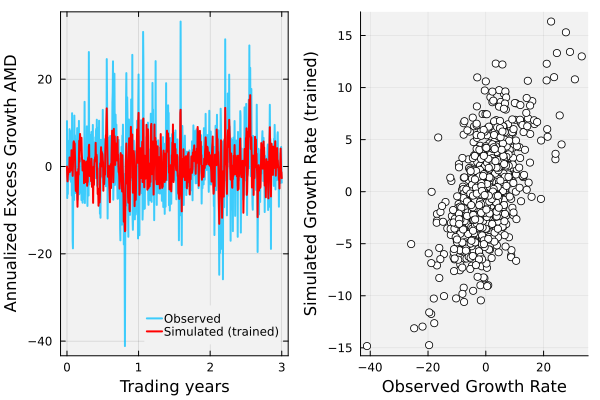

In [33]:
let

    # layout -
    l = @layout [a b]

    # time series -
    p1 = plot(T2,signal, label="Observed", lw=2, c=:deepskyblue, alpha=0.75, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
    plot!(p1, T2,Y2,label="Simulated (trained)", lw=2, c=:red, xlabel="Trading years", ylabel="Annualized Excess Growth $(ticker_of_interest)", fontsize=18)
    
    # sim v obs
    p2 = scatter(signal, Y2, label="", xlabel="Observed Growth Rate", ylabel="Simulated Growth Rate (trained)", c=:white, msc=:black)

    # build the plot -
    plot(p1,p2,layout=l)
end

In [34]:
corr_value = cor(signal,Y2);
println("Correclation for N = $(number_of_hidden_states) hidden states is: $(corr_value)")

Correclation for N = 250 hidden states is: 0.5832062656918435


## Visualize the Excess Growth Rate Distributions
Fill me in

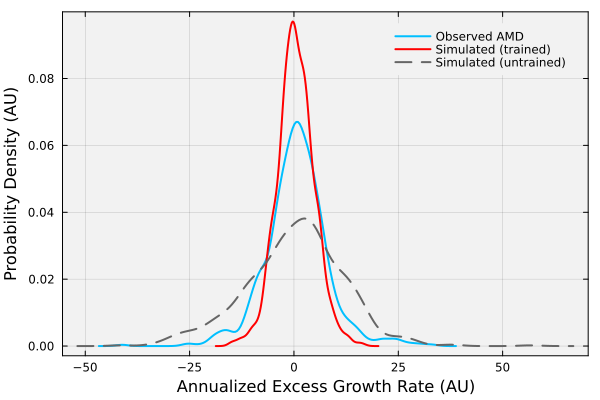

In [36]:
density(signal, label="Observed $(ticker_of_interest)", bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent, lw=2, c=:deepskyblue)
density!(Y2, normalize=true, c=:red, label="Simulated (trained)", lw=2)
density!(Y1, normalize=true, c=:gray40, label="Simulated (untrained)", lw=2, ls=:dash)
xlabel!("Annualized Excess Growth Rate (AU)", fontsize=18)
ylabel!("Probability Density (AU)", fontsize=18)

Fill me in

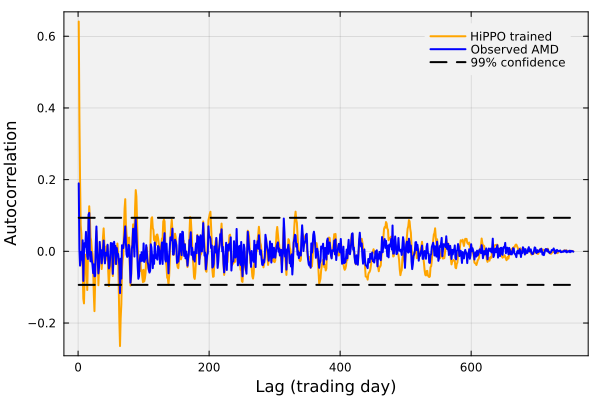

In [38]:
number_of_steps = length(Y2);
plot(autocor(Y2, (1:(number_of_steps - 1) |> collect)), label="HiPPO trained", lw=2, c=:orange, 
    bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
plot!(autocor(signal, (1:(number_of_steps-1)) |> collect), label="Observed $(ticker_of_interest)", lw=2, c=:blue)
LINE = (2.576/sqrt(number_of_steps))*ones(number_of_steps-1);
plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
xlabel!("Lag (trading day)", fontsize=18)
ylabel!("Autocorrelation", fontsize=18)

## Can the HiPPO model predict a return series?
Fill me in

In [40]:
d = fit_mle(Laplace, signal);
new_signal_vector = Array{Float64,1}();
for i ∈ 0:5*(252)
    r = rand(d);
    push!(new_signal_vector, r);
end

In [41]:
tspan = (start = 0.0, stop = 1.0, step = 1/252);
L = 100; # buffer
(T3,X3,Y3) = prediction(model_updated, tspan, new_signal_vector, L = L, B=40.0);

LoadError: MethodError: no method matching prediction(::MySisoLegSHippoModel, ::@NamedTuple{start::Float64, stop::Float64, step::Float64}, ::Vector{Float64}; L::Int64, B::Float64)

[0mClosest candidates are:
[0m  prediction(::MySisoLegSHippoModel, ::NamedTuple, ::Vector{Float64}; S, B, α, β)[91m got unsupported keyword argument "L"[39m
[0m[90m   @[39m [35mVLQuantitativeFinancePackage[39m [90m~/.julia/packages/VLQuantitativeFinancePackage/GSYGJ/src/[39m[90m[4mHippo.jl:38[24m[39m


Fill me in

In [43]:
let

    # layout -
    N = length(T3);

    # time series -
    p1 = plot(T3,new_signal_vector[1:N], label="Observed", lw=2, c=:deepskyblue, alpha=0.75, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
    plot!(p1, T3,Y3,label="Prediction L=$(L)", lw=2, c=:red, xlabel="Trading years", ylabel="Annualized Excess Growth $(ticker_of_interest)", fontsize=18)
end

LoadError: UndefVarError: `T3` not defined

Fill me in

In [45]:
density(Y3, label="HiPPO output $(ticker_of_interest)", lw=2, c=:red, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
density!(new_signal_vector,c=:gray, label="HiPPO input L = $(L)", lw=2, ls=:dash)
density!(excess_growth_rate_array, c=:deepskyblue, label="Observed $(ticker_of_interest)", lw=2)

LoadError: UndefVarError: `Y3` not defined

Fill me in

In [47]:
plot(autocor(Y3, (1:(number_of_steps-1) |> collect)), label="HiPPO prediction $(ticker_of_interest)", lw=2, c=:orange, 
    bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
plot!(autocor(excess_growth_rate_array, (1:(number_of_steps-1)) |> collect), label="Observed $(ticker_of_interest)", lw=2, c=:blue)
LINE = (2.576/sqrt(number_of_steps))*ones(number_of_steps-1);
plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
xlabel!("Lag (trading day)", fontsize=18)
ylabel!("Autocorrelation", fontsize=18)

LoadError: UndefVarError: `Y3` not defined

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.